<a href="https://colab.research.google.com/github/archangel2006/AgroNomics/blob/main/Crop_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AgroNomics : Crop Price Predictor

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import csv

with open("agridata.csv", "r", encoding="utf-8", errors="ignore") as infile, open("cleaned_agridata.csv", "w", newline="", encoding="utf-8") as outfile:
    reader = csv.reader(infile)
    writer = csv.writer(outfile)

    for row in reader:
        try:
            writer.writerow(row)
        except:
            continue  # skip any row that causes a write error


In [ ]:
df = pd.read_csv('/content/cleaned_agridata.csv')
df.shape

(409342, 8)

In [ ]:
df.columns

Index(['commodity_name', 'state', 'district', 'market', 'min_price',
       'max_price', 'modal_price', 'date'],
      dtype='object')

In [ ]:
df['commodity_name'].unique()

array(['Ajwan', 'Alasande+Gram', 'Amaranthus', 'Amla(Nelli+Kai)',
       'Amphophalus', 'Antawala', 'Apple', 'Arhar+Dal(Tur+Dal)',
       'Ashgourd', 'Avare+Dal', 'Banana', 'Banana+-+Green',
       'Barley+(Jau)', 'Beans', 'Beaten+Rice', 'Beetroot', 'Betal+Leaves',
       'Bitter+gourd', 'Black+pepper', 'Bottle+gourd', 'Brinjal',
       'Broken+Rice', 'Cabbage', 'Capsicum', 'Cardamoms', 'Carrot',
       'Cashewnuts', 'Castor+Seed', 'Cauliflower', 'Coconut',
       'Chapparad+Avare', 'Chennangi+Dal', 'Chikoos(Sapota)', 'Chili+Red',
       'Chilly+Capsicum', 'Cloves', 'Cluster+beans', 'Cocoa',
       'Coconut+Oil', 'Coconut+Seed', 'Coffee', 'Colacasia', 'Copra',
       'Coriander(Leaves)', 'Corriander+seed', 'Cowpea(Veg)', 'Cotton',
       'Cucumbar(Kheera)', 'Cummin+Seed(Jeera)', 'Drumstick',
       'Dry+Chillies', 'Dry+Fodder', 'Dry+Grapes', 'Duster+Beans', 'Egg',
       'Elephant+Yam+(Suran)', 'Field+Pea', 'Firewood', 'Fish', 'Garlic',
       'Ghee', 'Gingelly+Oil', 'Ginger(Dry)', 'Gi

In [ ]:
# Step 1: Clean commodity names by replacing "+" with spaces and fixing weird characters
df['commodity'] = (
    df['commodity_name']
    .str.replace('+', ' ', regex=False)            # Replace all "+" with spaces
    .str.replace(r'\+\-+\+', ' ', regex=True)      # Fix patterns like "+-+" (escaped properly)
    .str.strip()                                   # Remove extra spaces
)

# Step 2: Fix known typos to standardize commodity names
typo_fixes = {
    'Soji': 'Sooji',
    'Cucumbar(Kheera)': 'Cucumber',
    'Chilly Capsicum': 'Chilli Capsicum',
    'Corriander seed': 'Coriander seed',
    'Onion Green': 'Green Onion'
}
df['commodity'] = df['commodity'].replace(typo_fixes)


In [ ]:
df['commodity'].unique()

array(['Ajwan', 'Alasande Gram', 'Amaranthus', 'Amla(Nelli Kai)',
       'Amphophalus', 'Antawala', 'Apple', 'Arhar Dal(Tur Dal)',
       'Ashgourd', 'Avare Dal', 'Banana', 'Banana - Green',
       'Barley (Jau)', 'Beans', 'Beaten Rice', 'Beetroot', 'Betal Leaves',
       'Bitter gourd', 'Black pepper', 'Bottle gourd', 'Brinjal',
       'Broken Rice', 'Cabbage', 'Capsicum', 'Cardamoms', 'Carrot',
       'Cashewnuts', 'Castor Seed', 'Cauliflower', 'Coconut',
       'Chapparad Avare', 'Chennangi Dal', 'Chikoos(Sapota)', 'Chili Red',
       'Chilli Capsicum', 'Cloves', 'Cluster beans', 'Cocoa',
       'Coconut Oil', 'Coconut Seed', 'Coffee', 'Colacasia', 'Copra',
       'Coriander(Leaves)', 'Coriander seed', 'Cowpea(Veg)', 'Cotton',
       'Cucumber', 'Cummin Seed(Jeera)', 'Drumstick', 'Dry Chillies',
       'Dry Fodder', 'Dry Grapes', 'Duster Beans', 'Egg',
       'Elephant Yam (Suran)', 'Field Pea', 'Firewood', 'Fish', 'Garlic',
       'Ghee', 'Gingelly Oil', 'Ginger(Dry)', 'Ginger(Gree

In [ ]:
commodity_to_category = {}

# Grains
for item in ['Wheat', 'Rice', 'Maize', 'Jowar(Sorghum)', 'Millets', 'Ragi (Finger Millet)', 'Rajgir',
             'Barley (Jau)', 'Broken Rice', 'Maida Atta', 'Wheat Atta', 'Kodo Millet(Varagu)', 'Beaten Rice',
             'Sooji', 'Sajje','Hybrid Cumbu', 'T.V. Cumbu', 'Lak(Teora)']:
    commodity_to_category[item] = 'Grains'

# Pulses
for item in ['Arhar Dal(Tur Dal)', 'Masur Dal', 'Moath Dal', 'Chennangi Dal', 'Green Avare (W)', 'Avare Dal',
             'Peas(Dry)', 'Peas cod', 'Peas Wet', 'Alasande Gram', 'Field Pea', 'Indian Beans (Seam)',
             'Kulthi(Horse Gram)', 'Same/Savi', 'Gram Raw(Chholia)', 'White Peas', 'Arhar (Tur/Red Gram)(Whole)',
             'Mataki','Duster Beans', 'Guar']:
    commodity_to_category[item] = 'Pulses'

# Oilseeds
for item in ['Soyabean', 'Castor Seed', 'Sunflower', 'Groundnut', 'Ground Nut Seed', 'Linseed',
             'Groundnut (Split)', 'Groundnut pods (raw)', 'Safflower', 'Taramira', 'Niger Seed (Ramtil)',
             'Gurellu']:
    commodity_to_category[item] = 'Oilseeds'

# Vegetables
for item in ['Onion', 'Potato', 'Tomato', 'Cabbage', 'Brinjal', 'Beans', 'Beetroot', 'Bitter gourd',
             'Bottle gourd', 'Capsicum', 'Cauliflower', 'Cluster beans', 'Colacasia', 'Cucumber',
             'Drumstick', 'Green Peas', 'Pumpkin', 'Raddish', 'Ridgeguard(Tori)', 'Ridge gourd(Tori)',
             'Round gourd', 'Snakeguard', 'Snake gourd', 'Sponge gourd', 'Spinach', 'Knool Khol',
             'Leafy Vegetable', 'Turnip', 'Ashgourd', 'Carrot', 'Cowpea(Veg)', 'Green Chilli',
             'Elephant Yam (Suran)', 'Suvarna Gadde', 'Tinda', 'Chow Chow', 'Season Leaves', 'Amaranthus',
             'Mashrooms', 'Mint(Pudina)', 'Methi(Leaves)', 'Thondekai', 'Seemebadnekai', 'Bunch Beans','Sweet Potato',
             'Sweet Pumpkin', 'Yam', 'Yam (Ratalu)', 'Tapioca','Green Onion', 'Surat Beans (Papadi)', 'White Pumpkin', 'Kartali (Kantola)']:
    commodity_to_category[item] = 'Vegetables'

# Fruits
for item in ['Banana', 'Mango', 'Papaya', 'Guava', 'Pomegranate', 'Apple', 'Chikoos(Sapota)', 'Grapes',
             'Litchi', 'Plum', 'Peach', 'Jamun(Narale Hannu)', 'Water Melon', 'Mousambi(Sweet Lime)',
             'Karbuja(Musk Melon)', 'Pear(Marasebu)', 'Banana - Green', 'Papaya (Raw)', 'Mango (Raw-Ripe)',
             'Pineapple', 'Orange', 'Lemon', 'Lime', 'Long Melon(Kakri)', 'Jack Fruit', 'Seetapal',
             'Persimon(Japani Fal)', 'Seetafal', 'Amla(Nelli Kai)', 'Balekai', 'Galgal(Lemon)',
             'Almond(Badam)', 'Walnut', 'Cherry', 'Kinnow']:
    commodity_to_category[item] = 'Fruits'

# Spices & Oils
for item in ['Turmeric', 'Turmeric (raw)', 'Ginger(Dry)', 'Ginger(Green)', 'Cummin Seed(Jeera)', 'Garlic',
             'Mustard', 'Mustard Oil', 'Coconut Oil', 'Gingelly Oil', 'Black pepper', 'Cardamoms', 'Cloves',
             'Nutmeg', 'Pepper garbled', 'Pepper ungarbled', 'Tamarind Seed', 'Tamarind Fruit',
             'Dry Chillies', 'Soanf', 'Suva (Dill Seed)', 'Coriander(Leaves)', 'Coriander seed',
             'Ajwan', 'Chili Red', 'Chilli Capsicum', 'Mint(Pudina)', 'Methi Seeds', 'Isabgul (Psyllium)',
             'Betal Leaves','Mace','Toria']:
    commodity_to_category[item] = 'Spices/Oils'

# Flowers (Horticulture)
for item in ['Marigold(loose)', 'Marigold(Calcutta)', 'Chrysanthemum(Loose)', 'Jasmine', 'Tube Rose(Loose)',
             'Rose(Local)','Anthorium']:
    commodity_to_category[item] = 'Flowers'

# Cash Crops
for item in ['Coffee', 'Cotton', 'Cotton Seed', 'Rubber', 'Cashewnuts', 'Copra', 'Jute', 'Tobacco',
             'Sugarcane', 'Lint', 'Paddy(Dhan)(Basmati)', 'Paddy(Dhan)(Common)','Tender Coconut',
             'Arecanut(Betelnut/Supari)', 'Honge seed', 'Bamboo']:
    commodity_to_category[item] = 'Cash Crop'



# Processed / Value-Added Products
for item in ['Gur(Jaggery)', 'Sugar', 'Dry Grapes', 'Bran', 'Gramflour']:
    commodity_to_category[item] = 'Processed'

# Fodder / Fiber / Utility Crops
for item in ['Dry Fodder', 'Green Fodder', 'Dhaincha', 'Sunhemp', 'Lukad', 'Siddota']:
    commodity_to_category[item] = 'Fodder/Fiber'

# Non-Crop (Livestock or Derived)
for item in ['Egg', 'Fish', 'Hen', 'Cow', 'Goat', 'Sheep', 'Pigs', 'Calf', 'Ox', 'Duck', 'Cock',
             'She Buffalo', 'He Buffalo', 'Bull', 'Ram', 'She Goat', 'Khoya', 'Butter', 'Ghee', 'Firewood',
             'Wood', 'Dalda']:
    commodity_to_category[item] = 'Non-Crop'

# Other
for item in ['Amphophalus', 'Antawala', 'Chapparad Avare', 'Cocoa', 'Coconut', 'Coconut Seed', 'Mahua',
             'Myrobolan(Harad)', 'Neem Seed', 'Lotus Sticks', 'Alsandikai', 'Mahedi', 'Thogrikai', 'Ambada Seed',
             'Indian Colza(Sarson)', 'Sabu Dan', 'Sabu Dana', 'Coca', 'Hippe Seed', 'Rose(Loose)']:
    commodity_to_category[item] = 'Other'


In [ ]:
df.drop(columns=['commodity_name'], inplace=True)

In [ ]:
df['category'] = df['commodity'].map(commodity_to_category)

In [ ]:
df.head()

,state,district,market,min_price,max_price,modal_price,date,commodity,category
0,Gujarat,Amreli,Amreli,63.25,79.55,79.55,2019-05-22,Ajwan,Spices/Oils
1,Gujarat,Banaskanth,Dhanera,80.05,80.05,80.05,2019-05-22,Ajwan,Spices/Oils
2,Gujarat,Jamnagar,Jamnagar,90.00,155.00,122.50,2019-05-22,Ajwan,Spices/Oils
3,Gujarat,Mehsana,Kadi,94.50,112.50,107.00,2019-05-22,Ajwan,Spices/Oils
4,Gujarat,Mehsana,Unjha,21.25,148.50,99.75,2019-05-22,Ajwan,Spices/Oils


In [ ]:
# Removing rows that aren't crops

df = df[df['category']!='Non-Crop']

In [ ]:
df.category.unique()

array(['Spices/Oils', 'Pulses', 'Vegetables', 'Fruits', 'Other', 'Grains',
       'Cash Crop', 'Oilseeds', 'Fodder/Fiber', 'Processed', nan,
       'Flowers'], dtype=object)

In [ ]:
# Filter and display unique commodities with missing categories
missing_category_crops = df[df['category'].isna()]['commodity'].unique()
print("Commodities with missing categories:")
print(missing_category_crops)


Commodities with missing categories:
['Other Pulses' 'Padd']


In [ ]:
df = df[~df['commodity'].isin(['Other Pulses', 'its'])]
df = df[df['commodity'].notna()]


In [ ]:

missing_category_crops = df[df['category'].isna()]['commodity'].unique()
print("Commodities with missing categories:")
print(missing_category_crops)


Commodities with missing categories:
['Padd']


In [ ]:
df.category.unique()

array(['Spices/Oils', 'Pulses', 'Vegetables', 'Fruits', 'Other', 'Grains',
       'Cash Crop', 'Oilseeds', 'Fodder/Fiber', 'Processed', 'Flowers',
       nan], dtype=object)

In [ ]:
df.sample(5)

,state,district,market,min_price,max_price,modal_price,date,commodity,category
224056,Kerala,Palakad,Koduvayoor,26.00,42.00,30.00,2019-08-06,Amaranthus,Vegetables
288144,Uttar Pradesh,Firozabad,Sirsaganj,13.80,15.80,14.80,2019-08-24,Cucumber,Vegetables
217393,Rajasthan,Ganganagar,Sriganganagar,57.71,57.71,57.71,2019-10-02,Cotton,Cash Crop
70115,Uttar Pradesh,Pratapgarh,Pratapgarh,38.50,38.75,38.60,2019-07-05,Mustard,Spices/Oils
395685,West Bengal,Nadia,Chakdah,82.00,84.00,83.00,2019-11-10,Masur Dal,Pulses


In [ ]:
# STATES

df.state.unique()

array(['Gujarat', 'Madhya Pradesh', 'Rajasthan', 'Karnataka', 'Kerala',
       'Punjab', 'Uttar Pradesh', 'Chattisgarh', 'Haryana',
       'Himachal Pradesh', 'Maharashtra', 'NCT of Delhi', 'Odisha',
       'Uttrakhand', 'West Bengal', 'Assam', 'Manipur',
       'Jammu and Kashmir', 'Meghalaya', 'Nagaland', 'Tripura',
       'Telangana', 'Tamil Nadu', 'Andhra Pradesh', 'Pondicherry',
       'Jharkhand', 'Goa', 'Mizoram', 'Andaman and Nicobar', nan],
      dtype=object)

In [ ]:
# DISTRICTS

df.district.unique()

array(['Amreli', 'Banaskanth', 'Jamnagar', 'Mehsana', 'Neemuch',
       'Chittorgarh', 'Bagalkot', 'Bangalore', 'Gadag', 'Panna',
       'Ernakulam', 'Kollam', 'Thiruvananthapuram', 'Thirssur',
       'Alappuzha', 'Kozhikode(Calicut)', 'Kasargod', 'Palakad',
       'Malappuram', 'Pathanamthitta', 'Kottayam', 'Kannur', 'Wayanad',
       'Idukki', 'Sangrur', 'Kanpur', 'Chikmagalur', 'Durg', 'Karnal',
       'Faridabad', 'Hissar', 'Bhiwani', 'Kaithal', 'Fatehabad',
       'Sonipat', 'Kurukshetra', 'Mahendragarh-Narnaul', 'Jind',
       'Panipat', 'Mandi', 'Kangra', 'Sirmore', 'Solan', 'Harda',
       'Chandrapur', 'Kolhapur', 'Nashik', 'Pune', 'Delhi', 'Mayurbhanja',
       'Faridkot', 'Ferozpur', 'Gurdaspur', 'Hoshiarpur', 'Patiala',
       'Tarntaran', 'Ajmer', 'Ganganagar', 'Udaipur', 'Agra',
       'Ambedkarnagar', 'Aligarh', 'Maharajganj', 'Banda', 'Auraiya',
       'Azamgarh', 'Badaun', 'Ballia', 'Balrampur', 'Unnao', 'Barabanki',
       'Baghpat', 'Bareilly', 'Basti', 'Mainpuri', '

In [ ]:
# MARKET

df.market.nunique()

2153

In [ ]:
# distinct market values are too less in number compared to the number of rows in dataset, so we can drop market column

df = df.drop('market', axis=1)

In [ ]:
# columns left now

df.columns

Index(['state', 'district', 'min_price', 'max_price', 'modal_price', 'date',
       'commodity', 'category'],
      dtype='object')

In [ ]:
df['date'].dtype


dtype('O')

In [ ]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'], format='mixed',dayfirst=True)

# Extract month
df['month'] = df['date'].dt.month


In [ ]:
df['month'].unique()

array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., nan])

In [ ]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Summer'
    elif month in [6, 7, 8]:
        return 'Monsoon'
    else:
        return 'Post-Monsoon'

df['season'] = df['month'].apply(get_season)


In [ ]:
df = df.drop('date',axis=1)

In [ ]:
df.columns

Index(['state', 'district', 'min_price', 'max_price', 'modal_price',
       'commodity', 'category', 'month', 'season'],
      dtype='object')

In [ ]:
df.sample(3)

,state,district,min_price,max_price,modal_price,commodity,category,month,season
88146,Uttar Pradesh,Sitapur,21.00,23.00,22.20,Banana,Fruits,6.0,Monsoon
122024,Rajasthan,Kota,35.02,37.51,36.50,Soyabean,Oilseeds,6.0,Monsoon
135515,Uttar Pradesh,Pratapgarh,12.35,12.65,12.55,Bottle gourd,Vegetables,7.0,Monsoon


<Axes: xlabel='modal_price'>

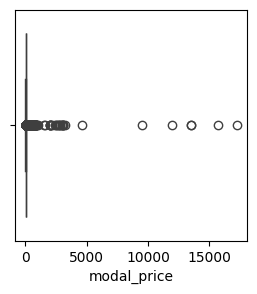

In [ ]:
plt.figure(figsize=(3,3))
sns.boxplot(x=df['modal_price'])

In [ ]:
Q1 = df['modal_price'].quantile(0.25)
Q3 = df['modal_price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['modal_price'] < lower_bound) | (df['modal_price'] > upper_bound)]
print(len(outliers), "out of", len(df), "rows")



24506 out of 407972 rows


In [ ]:
df = df[(df['modal_price'] >= lower_bound) & (df['modal_price'] <= upper_bound)]


In [ ]:
df.shape

(383465, 9)

In [ ]:
x = df[['category', 'commodity', 'state', 'district', 'month', 'season']]
y = df['modal_price']


In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
x_encoded = encoder.fit_transform(x)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_encoded, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=10, random_state=42)
model.fit(x_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=42)

In [ ]:
#import matplotlib.pyplot as plt

#plt.figure(figsize=(2,2))
#importances = model.feature_importances_
#feat_names = x.columns

#plt.barh(feat_names, importances)
#plt.xlabel("Importance")
#plt.title("Feature Importance")
#plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(x_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))


MAE: 3.364257086791101
RMSE: 32.964526609294545
R² Score: 0.8729833201815361


In [ ]:
import joblib

joblib.dump(model, 'crop_price_model2.pkl')  # Saving trained pipeline
joblib.dump(encoder, 'encoder.pkl')
from google.colab import files
files.download('encoder.pkl')
files.download('crop_price_model2.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>